# 1- Importing Required Libraries 📦

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



# 2- Loading Dataset 🗂️

In [2]:
df = pd.read_csv("malicious_phish.csv")
df.head()


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [6]:


# Rename 'benign' to 'safe'
df['type'] = df['type'].replace('benign', 'ham')
df['type'] = df['type'].apply(lambda x: 'ham' if x == 'ham' else 'spam')


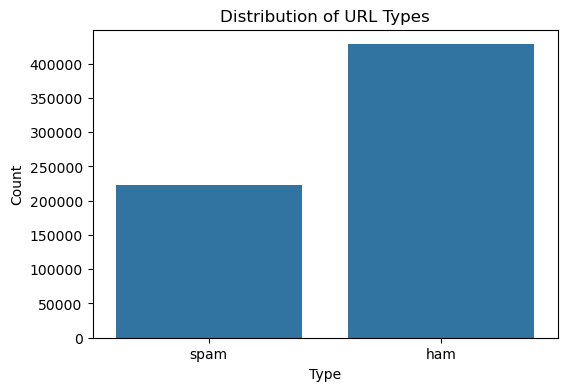

In [7]:
# ---  Distribution of URL Types ---
plt.figure(figsize=(6, 4))
sns.countplot(x='type', data=df)
plt.title('Distribution of URL Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# 4- Checking Missing Data 🔍

In [ ]:
# Check for missing values
print(df.isnull().sum())

url     0
type    0
dtype: int64


# 5- Encoding Target Labels 🏷️

In [9]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['type'])

In [10]:
df

,url,type,label_encoded
0,br-icloud.com.br,spam,1
1,mp3raid.com/music/krizz_kaliko.html,ham,0
2,bopsecrets.org/rexroth/cr/1.htm,ham,0
3,http://www.garage-pirenne.be/index.php?option=...,spam,1
4,http://adventure-nicaragua.net/index.php?optio...,spam,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,spam,1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,spam,1
651188,www.gamespot.com/xbox360/action/deadspace/,spam,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),spam,1


# 6-Lexical Feature Extraction 🔍

In [11]:
# suspicious keywords often seen in spam URLs
suspicious_keywords = ['login', 'signin', 'verify', 'update', 'banking', 'account', 'secure', 'ebay', 'paypal']

# feature extraction function
def extract_features(url):
    features = {}

    # Total length of the URL
    features['url_length'] = len(url)

    # Number of digits in the URL
    features['num_digits'] = sum(c.isdigit() for c in url)

    # Number of special characters (punctuation) in the URL
    features['num_special_chars'] = sum(c in string.punctuation for c in url)

    # Number of subdomains (i.e., number of dots minus one)
    features['num_subdomains'] = url.count('.') - 1

    # Whether the URL contains an IP address instead of a domain
    features['has_ip'] = 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0

    # Whether the URL uses HTTPS
    features['has_https'] = int('https' in url.lower())

    # Number of query parameters (indicated by '?')
    features['num_params'] = url.count('?')

    # Number of URL fragments (indicated by '#')
    features['num_fragments'] = url.count('#')

    # Total number of slashes in the URL
    features['num_slashes'] = url.count('/')

    # Whether the URL contains any suspicious keywords
    features['has_suspicious_words'] = int(any(word in url.lower() for word in suspicious_keywords))

    # Length of the top-level domain (e.g., "com", "net")
    tld = url.split('.')[-1]
    features['tld_length'] = len(tld)

    # Whether the TLD is a common one
    features['is_common_tld'] = int(tld in ['com', 'org', 'net', 'edu', 'gov'])

    # Whether the URL contains hexadecimal encoding (e.g., "%2F")
    features['has_hex'] = int(bool(re.search(r'%[0-9a-fA-F]{2}', url)))

    # Whether the URL has repeated characters (e.g., "aaaaa", "1111")
    features['repeated_chars'] = int(bool(re.search(r'(.)\1{3,}', url)))

    return pd.Series(features)

# Apply feature extraction
features_df = df['url'].apply(extract_features)
df = pd.concat([df, features_df], axis=1)
df.head()


,url,type,label_encoded,url_length,num_digits,num_special_chars,num_subdomains,has_ip,has_https,num_params,num_fragments,num_slashes,has_suspicious_words,tld_length,is_common_tld,has_hex,repeated_chars
0,br-icloud.com.br,spam,1,16,0,3,1,0,0,0,0,0,0,2,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,ham,0,35,1,5,1,0,0,0,0,2,0,4,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,ham,0,31,1,5,1,0,0,0,0,3,0,3,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,spam,1,88,7,18,2,0,0,1,0,3,0,53,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,spam,1,235,22,14,1,0,0,1,0,3,0,198,0,0,0


# 7- Feature Correlation Analysis 🌡️

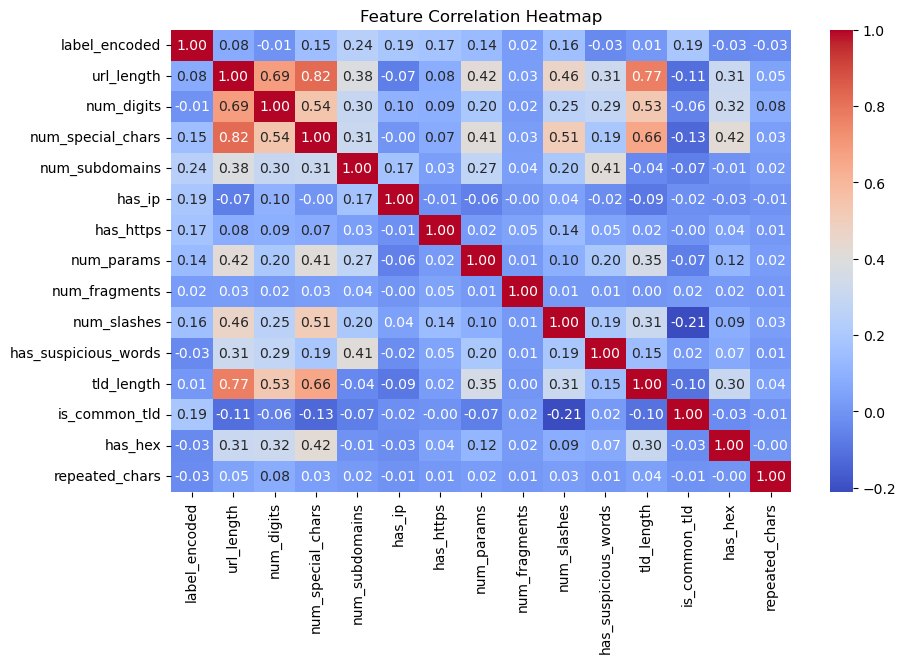

In [12]:
# --- 1 Correlation Heatmap ---
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature Correlation Heatmap')
plt.show()

# 8-Model Training & Evaluation 📊

In [13]:
# Define features and target
X = df.drop(columns=['url', 'type', 'label_encoded'])
y = df['label_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Dictionary to store model accuracies
accuracies = {}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"Accuracy for {name}: {acc:.4f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("\n")

Training XGBoost...
Accuracy for XGBoost: 0.9213
Classification Report for XGBoost:
              precision    recall  f1-score   support

         ham       0.94      0.94      0.94     85778
        spam       0.89      0.88      0.88     44461

    accuracy                           0.92    130239
   macro avg       0.91      0.91      0.91    130239
weighted avg       0.92      0.92      0.92    130239



Training Random Forest...
Accuracy for Random Forest: 0.9375
Classification Report for Random Forest:
              precision    recall  f1-score   support

         ham       0.95      0.95      0.95     85778
        spam       0.91      0.91      0.91     44461

    accuracy                           0.94    130239
   macro avg       0.93      0.93      0.93    130239
weighted avg       0.94      0.94      0.94    130239



Training K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.9188
Classification Report for K-Nearest Neighbors:
              precision    recall  f

# 9-Model Accuracy Comparison 📊

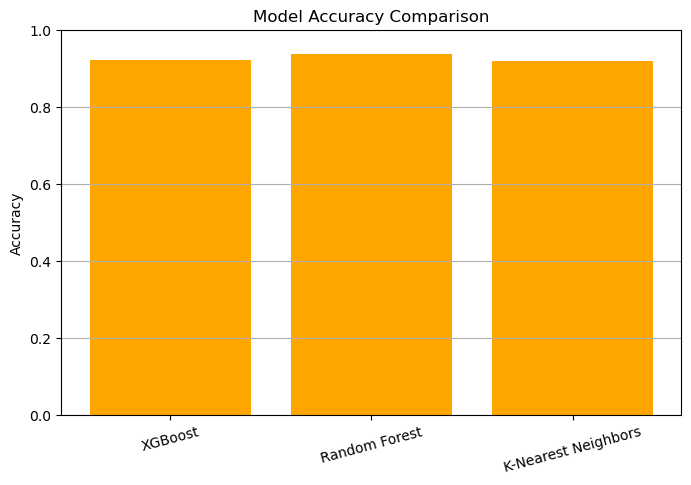

In [15]:
# Plot model accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='orange')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

In [17]:
import pickle

with open('link prediction model.pkl', 'wb') as file:
    pickle.dump(models['Random Forest'], file)

print("Model exported suucessfully!")

Model exported suucessfully!


**Conclusion:**

- The models show varying degrees of performance in classifying malicious URLs.
- Feature engineering plays a crucial role in model accuracy.


In [18]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import sklearn
import xgboost

# Print versions
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)


pandas: 2.2.2
numpy: 1.26.4
matplotlib: 3.8.4
seaborn: 0.13.2
scikit-learn: 1.4.2
xgboost: 3.0.0
